# 利用RNN來進行文本分類作業


## 讀取資料準備訓練資料，並且建立文字、預測類別數量

In [4]:
import os
import pickle
import numpy as np
import string
# Creating PT data samplers and loaders:
train_sampler =pickle.load(open('train.pkl','rb'))
valid_sampler = pickle.load(open('valid.pkl','rb'))
dataset = train_sampler+valid_sampler
print(len(train_sampler))
print(len(valid_sampler))
#建立文字列表
all_chars = list(set([d for p in dataset for d in p[1]]))

#總共出現的字數量
print(len(all_chars))

n_chars = len(all_chars)

all_categories = list(set([p[0] for p in dataset]))
n_categories = len(all_categories)
print(all_categories)

2892
722
2916
['politics', 'society', 'business', 'sports']


## 將文字轉成數值並且轉換成Tensor格式

In [5]:
import torch

# 從列表中找到文字代表的數字
def charToIndex(char):
    return all_chars.index(char)

# 從文字到數值tensor
def charToTensor(char):
    tensor = torch.zeros(1, n_chars)
    tensor[0][charToIndex(char)] = 1
    return tensor

#將整列轉換成數值tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_chars)
    for li, char in enumerate(line):
        tensor[li][0][charToIndex(char)] = 1
    return tensor
def linetoindexTensor(line):
    tensor = torch.zeros(len(line),1,dtype=torch.long)
    for i in range(0,len(line)):
        tensor[i][0] = charToIndex(line[i])
    return tensor

print(charToTensor('今'))

print(lineToTensor('今天真的好棒').size())

print(linetoindexTensor('今天真棒'))

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([6, 1, 2916])
tensor([[1528],
        [ 144],
        [1568],
        [2681]])


## 建立RNN模型

In [35]:
import torch.nn as nn
import torch.optim as optim
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,use_embedding):
        super(RNN, self).__init__()
#         embedding_dim = 300
#         self.word_embeddings = nn.Embedding(input_size, embedding_dim)
#         self.use_embedding = use_embedding
#         if self.use_embedding :
#             input_size = embedding_dim
        self.hidden_size = hidden_size
        #activation
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        #activation
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        #activation
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #concat input and last hidden(上一個的預測以及這一個的input)
#         if self.use_embedding:
#             input =  self.word_embeddings(input)
        combined = torch.cat((input, hidden), 1)
        #fully connected to hidden 
        hidden = self.i2h(combined)
        #Connected to tag
        output = self.i2o(combined)
        #Soft max get tag
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
#Create Model
rnn = RNN(n_chars, n_hidden, n_categories,False)
n_categories

4

In [36]:
input = charToTensor('今')
hidden =torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)
output

tensor([[-1.3747, -1.3851, -1.3765, -1.4092]], grad_fn=<LogSoftmaxBackward>)

In [37]:
input = lineToTensor('蔡英文今天發表演說')
print(input.shape)
hidden = torch.zeros(1, n_hidden)
print(hidden.shape)
print(input[0])
output, next_hidden = rnn(input[0], hidden)
print(len(next_hidden[0]))
output

torch.Size([9, 1, 2916])
torch.Size([1, 128])
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
128


tensor([[-1.4016, -1.3726, -1.3761, -1.3951]], grad_fn=<LogSoftmaxBackward>)

In [38]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print(all_categories)
print(categoryFromOutput(output))

['politics', 'society', 'business', 'sports']
('society', 1)


In [39]:

def Turn_input2tensor(category,line):
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = Turn_input2tensor(train_sampler[i][0],train_sampler[i][1])
    print('category =', category, '/ line =', line)

category = society / line = 毒販槍自抵太陽穴與警對峙1小時
category = society / line = 土城鵝肉名店遭縱火1死4傷
category = society / line = 刑事局前主秘╱許瑞山包庇賭場二審逆轉判3年4月
category = politics / line = 行政契約協商若無結果林峯正：婦聯會資產將被凍結
category = sports / line = 陽岱鋼談基層棒球：禮節比技術重要10倍
category = sports / line = 勇士換戲碼「浪花兄弟」險翻船
category = business / line = 義氣！侯貞雄捐錢捐鋼蓋台大社科院免冠名
category = sports / line = 冬盟》首場無四死球完封朴峻杓暫居雙冠王
category = politics / line = 民進黨布局2020英德配？清邁配？
category = sports / line = 百敗翻身奪外卡最佳總教練落雙城


## 設定Loss function－計算預測以及實際答案之間的差距
## NLLoss <- Negative Log Likelihood

In [40]:
criterion = nn.NLLLoss()

## 設定參數(learning rate)以及訓練流程

In [41]:
learning_rate = 0.01 # If you set this too high, it might explode. If too low, it might not learn
# optimizer = optim.SGD(model.parameters(), lr=0.1)
def train(model,category_tensor, line_tensor,word_index,use_embedding):
    hidden = model.initHidden()
    model.zero_grad()
    for i in range(line_tensor.size()[0]):
        if use_embedding:
            output, hidden = model(word_index[i], hidden)
        else:
            output, hidden = model(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        if p.grad is not None:
            p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [42]:
import time
import math

epochs = 3
print_every = 500
plot_every = 100
step = 0
n_steps = epochs*len(train_sampler)
n_hidden = 128
use_embedding = False


model = RNN(n_chars, n_hidden, n_categories,use_embedding)
print(model)
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, epochs + 1):
    for i in range(0,len(train_sampler)):
        category, line, category_tensor, line_tensor = Turn_input2tensor(train_sampler[i][0],train_sampler[i][1])
        word_index = linetoindexTensor(train_sampler[i][1])
        output, loss = train(model,category_tensor, line_tensor,word_index,use_embedding)
        current_loss += loss
        step+=1
        # Print iter number, loss, name and guess
        if step % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (step, step / n_steps * 100, timeSince(start), loss, line, guess, correct))
        # Add current loss avg to list of losses
        if step % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

RNN(
  (i2h): Linear(in_features=3044, out_features=128, bias=True)
  (i2o): Linear(in_features=3044, out_features=4, bias=True)
  (softmax): LogSoftmax()
)
500 5% (0m 15s) 1.3346 冬季聯盟／投野兩小獅驗收秋訓成果 / sports ✓
1000 11% (0m 30s) 1.3587 三星7奈米難產台積大吃高通訂單 / sports ✗ (business)
1500 17% (0m 46s) 1.3709 「比特幣是黃金2.0」比特幣億萬富翁自估再漲20倍 / sports ✗ (business)
2000 23% (1m 2s) 1.3663 同一地點／空姐才被潑糞又遭潑滾燙瀝青 / sports ✗ (society)


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])


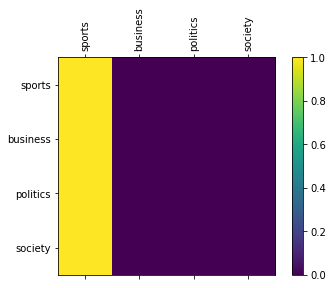

In [223]:

confusion = torch.zeros(n_categories, n_categories)
n_confusion = len(valid_sampler)
# Just return an output given a line
hidden = model.initHidden()
# print(model(torch.tensor([50]),hidden))
def evaluate(model,line_tensor,word_index,use_embedding):
    hidden = model.initHidden()
    for i in range(line_tensor.size()[0]):
        if use_embedding:
            output, hidden = model(word_index[i], hidden)
        else:
            output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = Turn_input2tensor(valid_sampler[i][0],valid_sampler[i][1])
    word_index = linetoindexTensor(valid_sampler[i][1])
    output = evaluate(model,line_tensor,word_index,use_embedding)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
print(confusion)
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [141]:
def evaluate(model,line_tensor,word_index,use_embedding):
    hidden = model.initHidden()
    for i in range(line_tensor.size()[0]):
        if use_embedding:
            output, hidden = model(word_index[i], hidden)
        else:
            output, hidden = model(line_tensor[i], hidden)
    return output

def predict(model,input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        word_index = linetoindexTensor(input_line)
        output = evaluate(model,lineToTensor(input_line),word_index,True)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# predict(model,'Dovesky')
# predict(model,'Jackson')
# predict(model,'Satoshi')

In [142]:
torch.save(model, "newsmodel.pt")

D:\Anaconda3\envs\pytorch_teach\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [143]:
news_model = torch.load('newsmodel.pt')

In [204]:
predict(news_model,'參選2020')
predict(news_model,'女友跨年上男人車..醋男談判反挨刀')


> 參選2020
(-0.75) business
(-1.56) society
(-1.60) sports

> 女友跨年上男人車..醋男談判反挨刀
(-0.95) society
(-1.26) politics
(-1.61) business
